In [1]:
SQLContext.newSession(sqlContext)
from pyspark.sql import functions as F
from pyspark.accumulators import AccumulatorParam
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.types import StringType,StructField,StructType,ArrayType,DoubleType
from pyspark.ml.linalg import Vectors, VectorUDT,Matrix,MatrixUDT,DenseMatrix
from pyspark.ml.feature import StandardScaler,VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql import Row
from pyspark.sql import Window

import re
import random
from prettytable import PrettyTable
import sys
from datetime import datetime
from operator import add
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score,silhouette_samples
#from spark_sklearn import GridSearchCV,Converter
PATH = "/home/svanhmic/workspace/Python/Erhvervs/data/cdata/"
regnskabsPath= "/home/svanhmic/workspace/Python/Erhvervs/data/regnskabsdata/sparkdata/parquet"

The following data frame contains the same data as in the bancruptcy and outlier method. 

In [2]:
#import data and rename bad name rank into vaerdiSlope
cvrDf = sqlContext.read.parquet(PATH+"featureDataCvr")
regnDf =sqlContext.read.parquet(regnskabsPath+"/formatAndCleanedRegnskaber.parque")

rankCols = [re.sub(pattern="rank_",repl="vaerdiSlope_",string=i) for i in cvrDf.columns ]
renamedDf = (cvrDf
             .withColumn(colName="reklamebeskyttet",col=F.col("reklamebeskyttet").cast("integer"))
             .select([F.col(val).alias(rankCols[idx]) for idx,val in enumerate(cvrDf.columns)])
            )
#renamedDf.show()

In [3]:
#regnDf.show()

In [4]:
#regnDf.printSchema()
dcolsRegnDict = dict(regnDf.dtypes)
print(regnDf.count())
#regnDf.describe().show()
doubleFeatures = list(i for i in dcolsRegnDict.keys() if dcolsRegnDict[i] not in ["string","date"])
len(doubleFeatures)

9447


23

###  The data is visualised 

In [6]:
import matplotlib.pyplot as plt
import pandas
from pandas.tools.plotting import scatter_matrix
import seaborn as sb

In [7]:
doublePDf = (regnDf
             .select(doubleFeatures)
             .toPandas()) #topandas dataframe
#print(np.log1p(doublePDf["Assets"])+100)
loggedPDF = doublePDf.apply(np.log1p)

describePandasDf = loggedPDF.describe()
counts = describePandasDf.filter(like="count",axis=0).transpose()
above = counts[(counts > 8000).any(axis=1)]
columns = [i for i in above.index.values if i not in ("id","IdentificationNumberCvrOfReportingEntity","IdentificationNumberCvrOfSubmittingEnterprise")]
columns

['ShorttermReceivables',
 'Assets',
 'ProfitLoss',
 'ContributedCapital',
 'ShorttermLiabilitiesOtherThanProvisions',
 'OtherShorttermPayables',
 'LiabilitiesOtherThanProvisions',
 'CurrentAssets',
 'Equity',
 'LiabilitiesAndEquity']

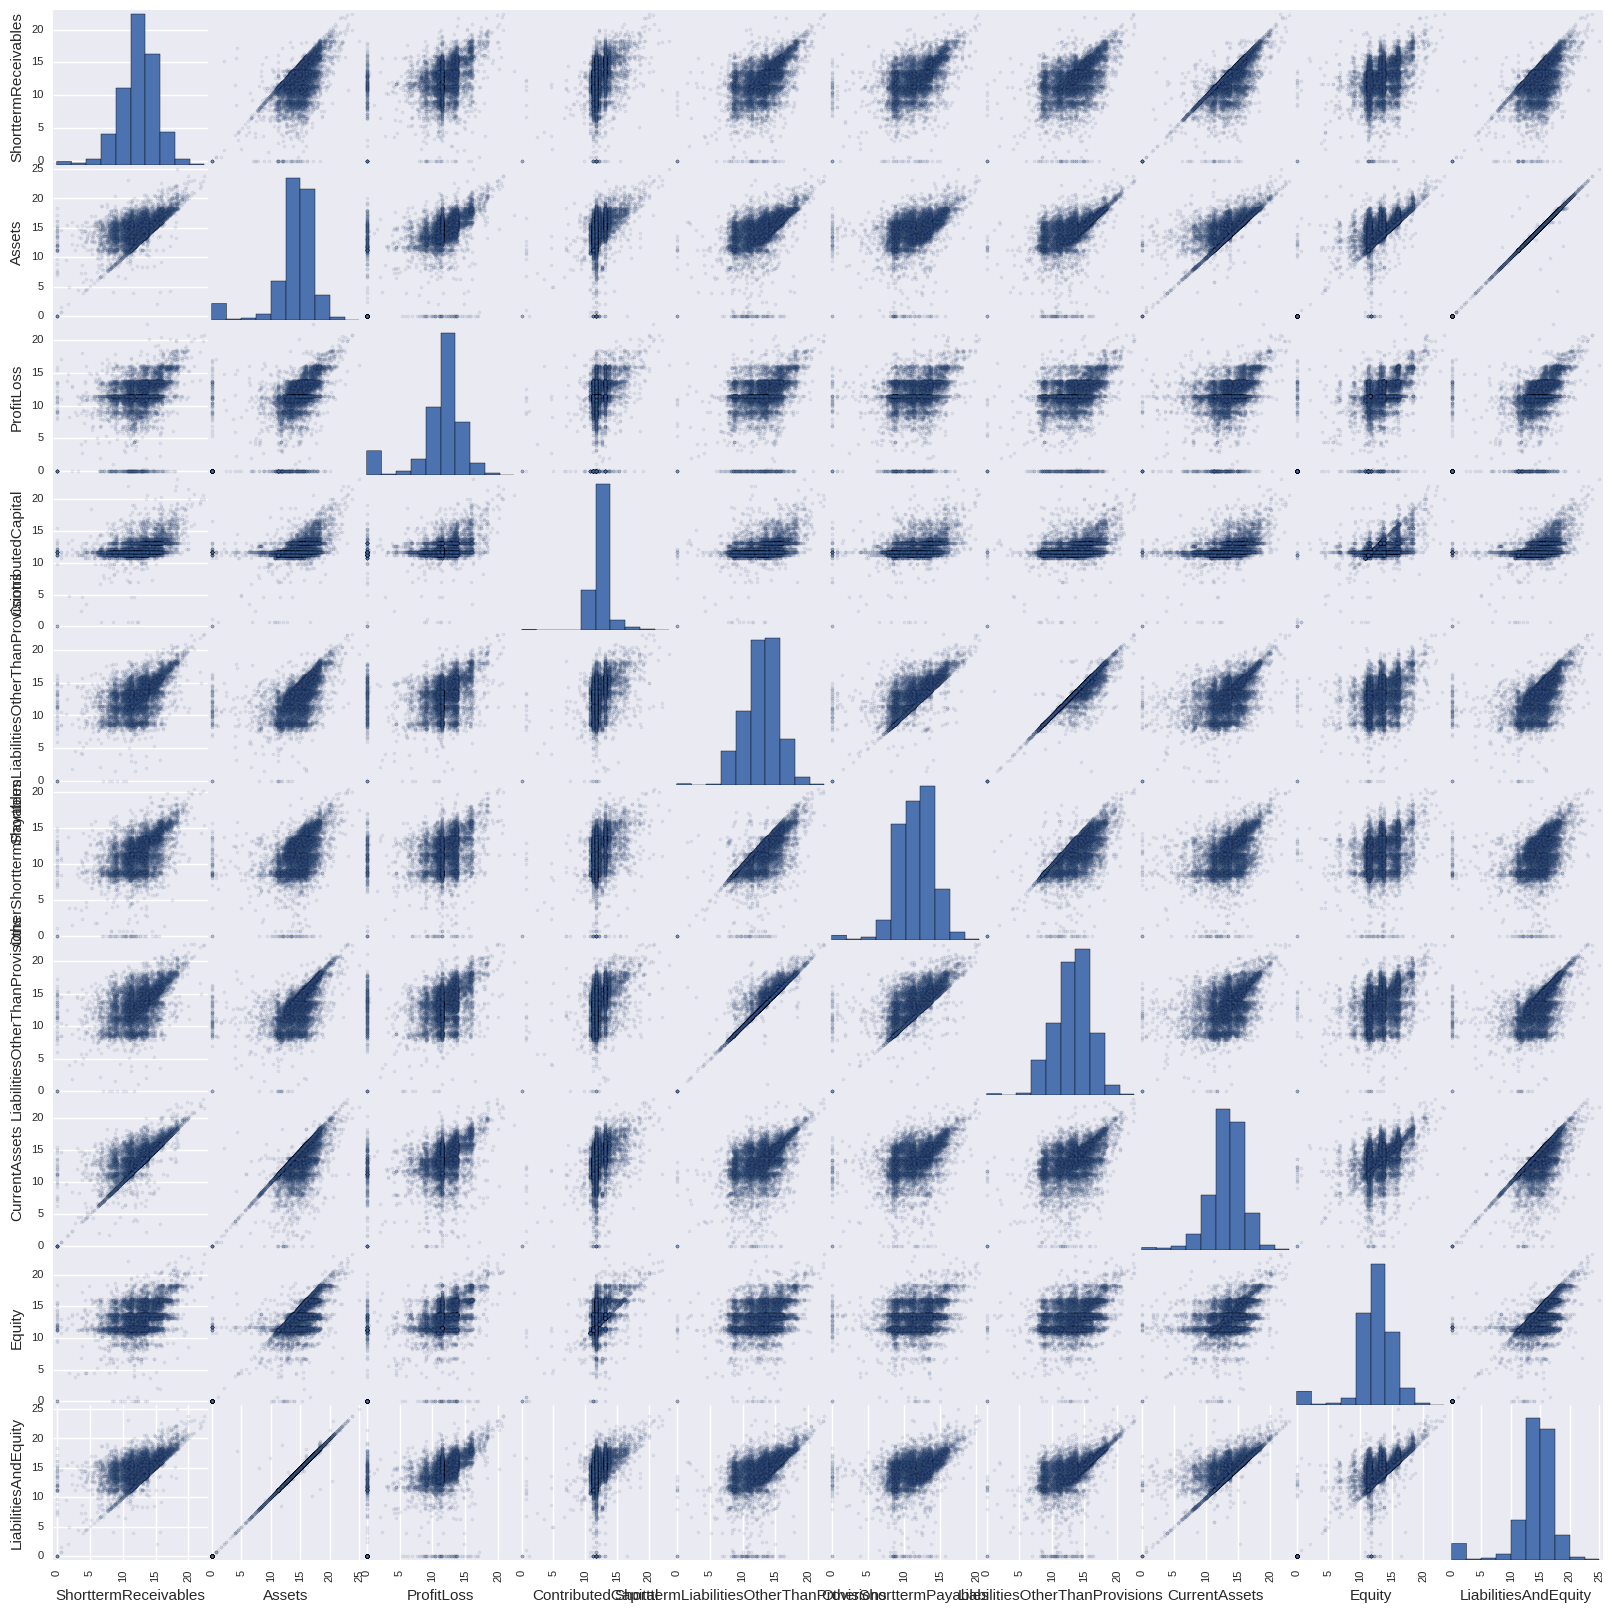

In [53]:
scatter_matrix(loggedPDF[columns],alpha=0.1,figsize=(20,20))
plt.show()

Assets and LiabilitiesAndEquity are highlig correlated. Again shown in the plot below.

ShorttermLiabilitiesOtherThanProvisions, OtherShorttermPayables and LiabilitiesOtherThanProvisions are correlated to some degree...

Equity and LiabilitiesAndQuity are correlated to some degree. 


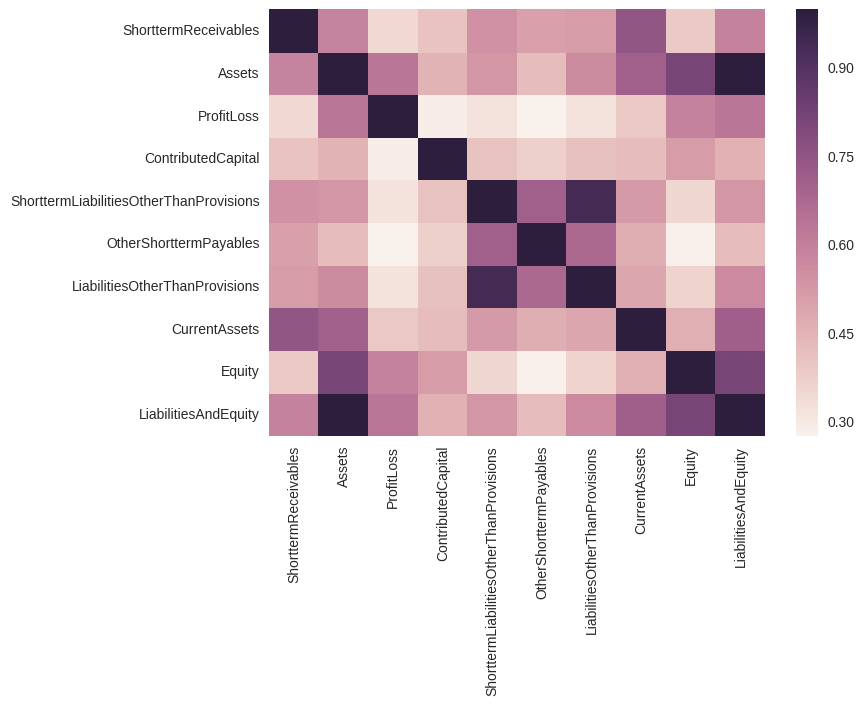

In [54]:
corrMatrixPDf = loggedPDF[columns].corr()
sb.heatmap(corrMatrixPDf, 
            xticklabels=corrMatrixPDf.columns.values,
            yticklabels=corrMatrixPDf.columns.values)
plt.show()

In [10]:
#renamedDf.printSchema()

In [11]:
holdOutCols = ["cvrNummer","status","label"]
inputCols = [i for i in renamedDf.columns if i not in holdOutCols]
toDenseUdf = F.udf(lambda x: Vectors.dense(x.toArray()),VectorUDT())

vectorMaker = VectorAssembler(inputCols=inputCols,outputCol="features")
vectorDf = (vectorMaker
            .transform(renamedDf.na.fill(0.0))
            .select(toDenseUdf(F.col("features")).alias("features"))
           )

#vectorDf.show()


standardScale = StandardScaler(withMean=True,withStd=True,inputCol=vectorMaker.getOutputCol(),outputCol="scaledFeatures")
standardScaleModel = standardScale.fit(vectorDf)
standardDf = (standardScaleModel
              .transform(vectorDf)
              .select(F.col("scaledFeatures"))
             )
#standardDf.show()

In [12]:
FeatureRow = Row(*inputCols)
standardPDf = (standardDf
               .rdd
               .map(lambda x: dict(zip(inputCols,[float(i) for i in x[0].toArray()])))
               .toDF()
               .toPandas()
              )

/usr/local/share/spark/python/pyspark/sql/session.py:336: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


   AarsVaerk_1  AarsVaerk_10  AarsVaerk_11  AarsVaerk_12  AarsVaerk_13  \
0     1.595954      0.800151      2.288656      0.915913      1.010886   
1     0.532856      0.346680      0.377206      0.410307      0.460644   
2    -0.140440     -0.016098     -0.005084      0.157505      0.185523   
3    -0.140440     -0.106792     -0.100657     -0.095298     -0.089598   

   AarsVaerk_14  AarsVaerk_15  AarsVaerk_2  AarsVaerk_3  AarsVaerk_4  \
0      1.045827      1.140534     1.534284     1.499297     1.471239   
1      0.484727      0.535835     0.497877     0.494692     0.490718   
2      0.035847      0.052076    -0.158514    -0.141558    -0.130278   
3     -0.076373     -0.068864     0.152408     0.159824     0.163878   

       ...        reklamebeskyttet  totalAabneEnheder  totalLukketEnheder  \
0      ...               -0.242767          -0.045972             0.25017   
1      ...               -0.242767          -0.278666             0.25017   
2      ...                4.119155   

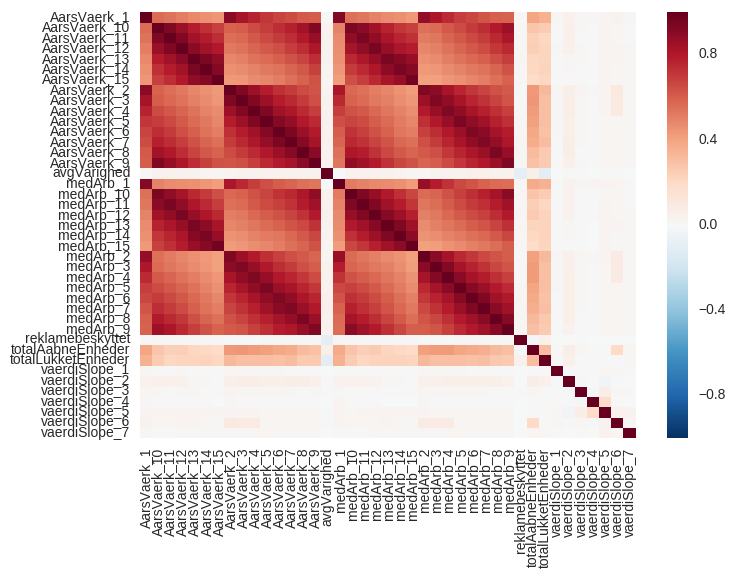

In [151]:

print(standardPDf[standardPDf.columns][:4])
corrMatrixPDf = standardPDf.corr()

sb.heatmap(corrMatrixPDf, 
            xticklabels=corrMatrixPDf.columns.values,
            yticklabels=corrMatrixPDf.columns.values)
plt.show()

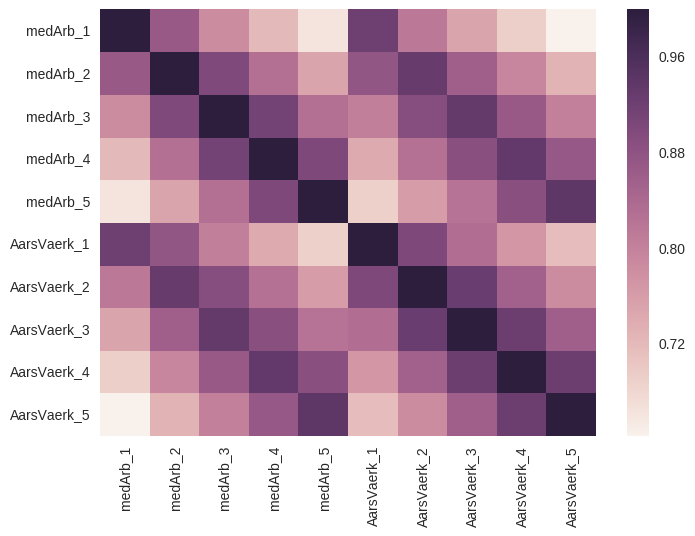

In [161]:
medArbCols = ["medArb_"+str(i) for i in range(1,6)]
AarsVaerCols = ["AarsVaerk_"+str(i) for i in range(1,6)]
medarbejdPDf = standardPDf.ix[:,medArbCols+AarsVaerCols]
corrMatrixPDf = medarbejdPDf.corr()

sb.heatmap(corrMatrixPDf, 
            xticklabels=corrMatrixPDf.columns.values,
            yticklabels=corrMatrixPDf.columns.values)
plt.show()

In [228]:
#plot scatter matrix

#scatter_matrix(medarbejdPDf,alpha=0.1,figsize=(20,20))
#plt.show()

In [207]:
def computeRatio(aarsvaerk,medarbejd):
    if (medarbejd == None) or (aarsvaerk == None) :
        return 0.0
    elif (medarbejd == 0):
        return float(np.log1p(aarsvaerk/0.5 ))
    else:
        return float(np.log1p(aarsvaerk/medarbejd))

computeAarsMedRatioUdf = F.udf(lambda x,y: computeRatio(x,y),DoubleType())
ratioCols = [computeAarsMedRatioUdf(AarsVaerCols[i],medArbCols[i]).alias("ArsOverMedarbj"+str(i+1)) for i in range(len(AarsVaerCols))]

aarsVaerkToMedarbjdDf = renamedDf.select(holdOutCols+ratioCols).distinct()
aarsVaerkToMedarbjdDf.orderBy(["ArsOverMedarbj"+str(i+1) for i in range(5)],ascending=[0,0,0,0,0]).show()

+---------+--------------------+-----+-----------------+-------------------+-------------------+-------------------+------------------+
|cvrNummer|              status|label|  ArsOverMedarbj1|    ArsOverMedarbj2|    ArsOverMedarbj3|    ArsOverMedarbj4|   ArsOverMedarbj5|
+---------+--------------------+-----+-----------------+-------------------+-------------------+-------------------+------------------+
| 24213714|[OPLØST EFTER FUS...|    1|7.601402334583733| 0.6931471805599453| 0.6931471805599453| 0.6931471805599453|0.6931471805599453|
| 39661314|[OPLØST EFTER FUS...|    1|7.601402334583733| 0.6931471805599453| 0.6931471805599453| 0.6931471805599453|0.6931471805599453|
| 16994294|[OPLØST EFTER SPA...|    1| 6.90875477931522| 0.6931471805599453| 0.6931471805599453| 0.6931471805599453|0.6931471805599453|
| 28710380|[OPLØST EFTER KON...|    0|5.993961427306569|  1.252762968495368| 0.6931471805599453|0.22314355131420976|               0.0|
| 12703031|[OPLØST EFTER FUS...|    1|5.99396142

In [224]:
#check if some cvrs are overlapping
overlapDf = (renamedDf
             .join(regnDf,renamedDf["cvrNummer"]==regnDf["IdentificationNumberCvrOfReportingEntity"],"inner")
             .select(renamedDf.columns+doubleFeatures)
            )
overlapDf.show(1)

+---------+--------+-----+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+-----------+-----------------+------------------+------------------+-----------------+-------------+-------------+-------------+-------------+-------------+----------------+----------------+--------------------+----------------------+----------------+----------------+---------+----------+------------------+---------------------------------------+-----------------------------------------+---------------------------------------------+-----------------------------------------+-----------------------+--------------------+----------------------+------------------+------------------------------+----------+-------------+--------+---+-------------

In [ ]:
overlapDf